# Quora Insincere Questions classification based on TF-IDF
## using sklearn logistic regression

In [2]:
import re
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
WORKING_DIR = os.path.join('.input', 'tfidf_logistic')

In [4]:
quora = pd.read_csv('../data/.input/train.csv', nrows=20_000)

In [5]:
quora.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [6]:
quora_train, quora_test = train_test_split(quora, random_state=42)
quora_train_data = quora_train.question_text
quora_train_labels = quora_train.target
quora_test_data = quora_test.question_text
quora_test_labels = quora_test.target

In [7]:
%time
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

train_X = vectorizer.fit_transform(quora_train_data)
train_y = quora_train_labels

Wall time: 0 ns


In [8]:
test_X = vectorizer.transform(quora_test_data)
test_y = quora_test_labels

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, roc_curve

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

def report_results(clf, test_X, test_y):
    test_predict_proba = clf.predict_proba(test_X)
    test_predict_proba_pos = test_predict_proba[:, 1]
    auc = roc_auc_score(test_y, test_predict_proba_pos)
    curve = roc_curve(test_y, test_predict_proba_pos)


    plt.plot(curve[0], curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);
    
    to_labels = np.vectorize(lambda x: 1 if x > 0.5 else 0)
    test_predict = to_labels(test_predict_proba_pos)

    print('accuracy', accuracy_score(test_y, test_predict))
    print('precision', precision_score(test_y, test_predict))
    print('recall', recall_score(test_y, test_predict))
    print('f1', f1_score(test_y, test_predict))
    print('AUC', auc)
    confusion_matrix(test_y, test_predict)


## Logistic Regression

In [10]:
%%time

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='saga', C = 0.5, class_weight='balanced', random_state=42, max_iter=500)
clf.fit(train_X, train_y)

Wall time: 4.35 s


c:\users\alexa\.virtualenvs\ml-awwz4wov\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy 0.8488
precision 0.2436040044493882
recall 0.7423728813559322
f1 0.36683417085427134
AUC 0.8826455807921614


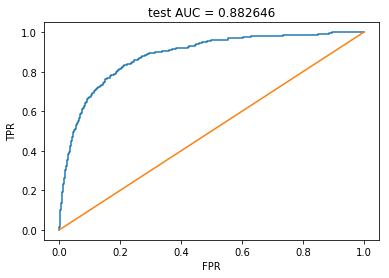

In [11]:
report_results(clf, test_X, test_y)

## Grid Search

In [12]:
%%time

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

params_grid = [{'solver': ['saga'], 'C': [0.1, 0.5, 5.0], 'class_weight': [None, 'balanced'], 'penalty': ['l1', 'l2']},
               {'solver': ['newton-cg', 'sag'], 'C': [0.1, 0.5, 5.0], 'class_weight': [None, 'balanced'], 'penalty': ['l2']}]

clf = LogisticRegression(random_state=42, max_iter=500)

grid_search = GridSearchCV(clf, params_grid, cv=5, return_train_score=True, n_jobs=-1)

grid_search.fit(train_X, train_y)

Wall time: 2min 9s


In [13]:
for score, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
        print(score, params)

print('\nbest params', grid_search.best_params_)

0.936 {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
0.9359333333333333 {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
0.7410666666666667 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
0.8508666666666667 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
0.9398 {'C': 0.5, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
0.9374666666666667 {'C': 0.5, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
0.8530666666666666 {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
0.8143333333333334 {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
0.9413333333333334 {'C': 5.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
0.9432 {'C': 5.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
0.9156666666666666 {'C': 5.0, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
0.9046 {'C': 5.0, 'class_weight': 'balanced', 'pen

accuracy 0.9472
precision 0.6396396396396397
recall 0.24067796610169492
f1 0.3497536945812808
AUC 0.9033188638123886


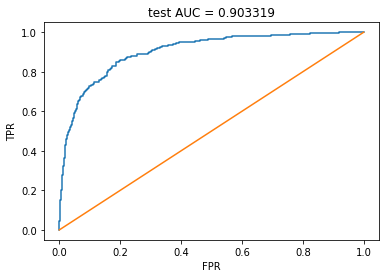

In [14]:
report_results(grid_search.best_estimator_, test_X, test_y)